# TODO
[#2](https://github.com/caelum02/LuX-AI-Season-2/issues/2)
Observation to Input

In [22]:
import jux
from jux.env import JuxEnv
from jux.config import JuxBufferConfig
from jux.state import State
from jux.actions import JuxAction

import jax
import jax.numpy as jnp

import rich
import matplotlib.pyplot as plt

In [23]:
def replay_skip_until_late_game(jux_env: JuxEnv, initial_state: State, lux_actions):
    """
        Util function | skip game until late_game stage
        
        return:
            state: game state right after factory placement phase
            lux_actions: lux action iterator synchronized to `state`
    """    
    # Bid Step
    bid, faction = jux.actions.bid_action_from_lux(next(lux_actions))
    state, (obs, rwd, dones, infos) = jux_env.step_bid(initial_state, bid, faction)

    # Factory Placement Step
    while state.real_env_steps < 0:
        lux_act = next(lux_actions)
        spawn, water, metal = jux.actions.factory_placement_action_from_lux(lux_act)
        state, (obs, rwd, dones, infos) = jux_env.step_factory_placement(state, spawn, water, metal)
    
    return state, lux_actions

def run_n_late_game_step(n: int, jux_env: JuxEnv, state: State, lux_actions):
    for _ in range(n):
        lux_act = next(lux_actions)
        jux_act = JuxAction.from_lux(state, lux_act)

        # step
        state, (observations, rewards, dones, infos) = jux_env.step_late_game(state, jux_act)
    
    return state, lux_actions

In [27]:
lux_env, lux_actions = jux.utils.load_replay('https://www.kaggleusercontent.com/episodes/52900827.json')
jux_env, state = JuxEnv.from_lux(lux_env, buf_cfg=JuxBufferConfig(MAX_N_UNITS=200))
state, lux_actions = replay_skip_until_late_game(jux_env, state, lux_actions)
state, lux_actions = run_n_late_game_step(376, jux_env, state, lux_actions)

In [29]:
2**15

32768

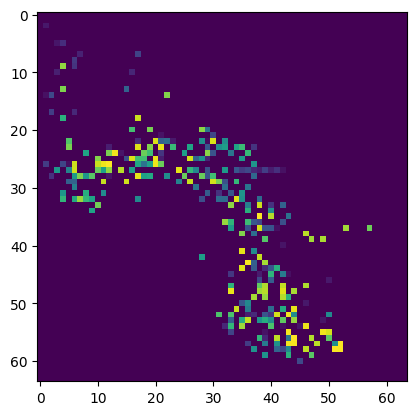

In [31]:
plt.imshow(state.board.units_map * (state.board.units_map != 32767))

In [26]:
state.unit_id2idx[37]

Array([ 0, 10], dtype=int16)

In [32]:
from jux.unit import UnitType 
from jax import vmap, jit
from functools import partial

@partial(vmap, in_axes=0)
def add_at_mask(array, x, y, mask):
    out = jnp.zeros_like(array)
    out = out.at[x, y].add(mask, mode='drop')
    return out

@jit
def get_unit_existence(unit_mask, unit_type, x, y, MAP_SIZE=state.env_cfg.map_size):
    '''
        unit_type : ShapedArray(int8[2, MAX_N_UNITS])
        unit_mask : ShapedArray(bool[2, MAX_N_UNITS])
        x : ShapedArray(int8[2, MAX_N_UNITS])
        y : ShapedArray(int8[2, MAX_N_UNITS])

        output: ShapedArray(int8[4, MAX_N_UNITS])

        light player 0, light player 1, heavy player 0, heavy player 1

        unit type goes to axis 0 to preserve locality of player & unit_id axis
    '''

  
    light_mask = unit_mask & (unit_type==UnitType.LIGHT)
    heavy_mask = unit_mask & (unit_type==UnitType.HEAVY)

    zeros = jnp.zeros((2, MAP_SIZE, MAP_SIZE), dtype=jnp.int8)

    # `mode=drop` prevents unexpected index-out-of-bound behavior
    light_unit_map = add_at_mask(zeros, x, y, light_mask)
    heavy_unit_map = add_at_mask(zeros, x, y, heavy_mask)

    unit_map = jnp.concatenate((light_unit_map, heavy_unit_map))
    
    return unit_map

unit_map = get_unit_existence(state.unit_mask, state.units.unit_type, state.units.pos.x, state.units.pos.y)

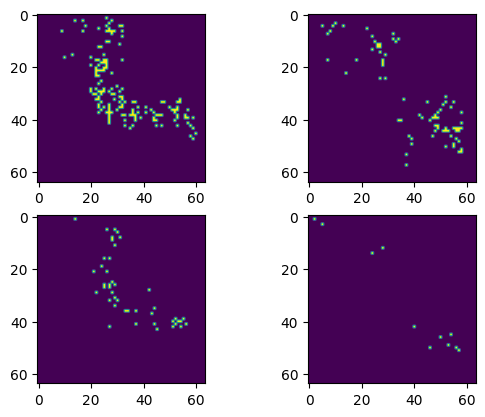

In [33]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(unit_map[0].T)
axes[0, 1].imshow(unit_map[1].T)
axes[1, 0].imshow(unit_map[2].T)
axes[1, 1].imshow(unit_map[3].T)
plt.show()




#### Guarantees
```python
observations['player_0'] == observations['player_1'] == state
dones['player_0'] == dones['player_1']
infos['player_0'] == infos['player_1'] == {}
```

## Understanding the `State`

`State` object is a nested `NamedTuple`, with all leaves being `jax.numpy.ndarray`. It has following fields. 

In [14]:
state._fields

('env_cfg',
 'seed',
 'rng_state',
 'env_steps',
 'board',
 'units',
 'unit_id2idx',
 'n_units',
 'factories',
 'factory_id2idx',
 'n_factories',
 'teams',
 'global_id',
 'place_first')

### Board Information

Information about the board, including rubble, ice, ore, and lichen, are stored in `state.board`.

In [13]:
import jux.tree_util
import rich
rich.print(jux.tree_util.map_to_aval(state.board))

Board(
    seed=ShapedArray(int32[]),
    factories_per_team=ShapedArray(int8[]),
    map=GameMap(
        rubble=ShapedArray(int8[48,48]),
        ice=ShapedArray(bool[48,48]),
        ore=ShapedArray(bool[48,48]),
        symmetry=ShapedArray(int8[])
    ),
    lichen=ShapedArray(int32[48,48]),
    lichen_strains=ShapedArray(int8[48,48]),
    units_map=ShapedArray(int16[48,48]),
    factory_map=ShapedArray(int8[48,48]),
    factory_occupancy_map=ShapedArray(int8[48,48]),
    factory_pos=ShapedArray(int8[22,2])
)

### Factory Information

All information about factories, including their position, cargo, and power, are stored in `state.factories`. `state.n_factories` indicates the number of factories each player has. Because we have just reset the environment, both players have 0 factory. The leaves of `state.factories` have shapes shown as below. 

In [14]:
print(f"{state.n_factories = }")
rich.print(jux.tree_util.map_to_aval(state.factories))

state.n_factories = Array([2, 2], dtype=int8)


Factory(
    team_id=ShapedArray(int8[2,11]),
    unit_id=ShapedArray(int8[2,11]),
    pos=Position(pos=ShapedArray(int8[2,11,2])),
    power=ShapedArray(int32[2,11]),
    cargo=UnitCargo(stock=ShapedArray(int32[2,11,4]))
)

## Run a Batch of Environments
Running a single environment cannot take full advantage of the power of modern GPU. This section will show you how to run a batch of environments at once. We first create a `JuxEnvBatch` object.

In [25]:
from jux.env import JuxEnvBatch

jux_env_batch = JuxEnvBatch(buf_cfg=JuxBufferConfig(MAX_N_UNITS=200))

Then, reset the environment to get initial states. Instead of passing in a single seed, we pass in a batch of seeds. The batch size is determined by the size of the seed array.

In [26]:
import jax.numpy as jnp

batch_size = 2
seeds = jnp.arange(batch_size)

states = jux_env_batch.reset(seeds)

Note that the default env rendering function is CPU based and only works for non batched environments. In order to render the environments, we recommend you construct the images you need yourself when needed, especially since generating evaluation videos of 1000s of parallel environments is slow due to I/O of video creationg becoming a bottleneck. Regardless, visualizations are helpful and an example showing the distribution of resources on each batched environment is shown below.

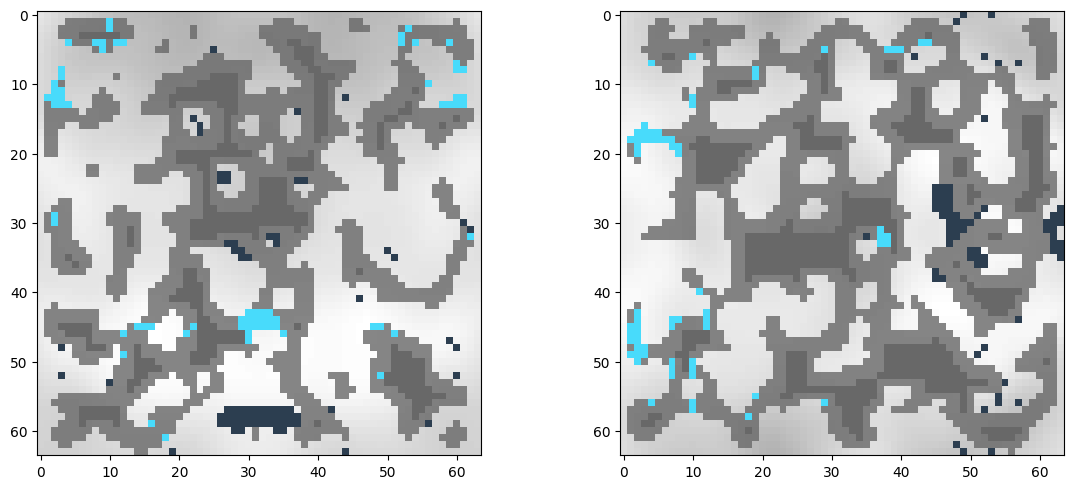

In [27]:
import cv2
import numpy as np
# create images of each episode from board state data in a vectorized fashion. These will generate colors close to the real visualizer, 
# serves as good starting point for building your own visualizations
# it's a bit more complex to further generate some other details in the game for visualization e.g. units, text etc., in addition to trying to generate 
# 1000s of videos of episodes at a time, making it no faster than simply just evaluating on CPU (I/O of creating videos becomes a bottleneck)
# we leave that to you the user to decide what to do with visualization with some useful vectorized code below

# rubble = states.board.map.rubble[i]
imgs = np.zeros((batch_size, 64, 64, 3))
for c in [0, 1, 2]:
    imgs[:, :, :, c] = ((np.array(states.board.map.rubble) / 100)*(1-0.411) + 0.411)
# color in ice and ore
imgs[states.board.map.ice == True] = np.array([72, 219, 251]) / 255.0
imgs[states.board.map.ore == True] = np.array([44, 62, 80]) / 255.0
# imgs[states.board.factory_occupancy_map

# for sake of space, we will just plot the first 5 environments
fig,axs = plt.subplots(1, 2, figsize=(12,5))
axs = axs.flatten()
for i in range(len(axs)):
    ax = axs[i]    
    ax.imshow(imgs[i])
plt.tight_layout()

According to our attribute-first memory layout, states is still a `State` object, but all leaves are added with a leading dimension of `batch_size` as shown below. E.g. `unit_id` transforms from shape `(2, 11)` to `(batch_size, 2, 11)`

In [28]:
rich.print(jux.tree_util.map_to_aval(states.factories))

Factory(
    team_id=ShapedArray(int8[2,2,11]),
    unit_id=ShapedArray(int8[2,2,11]),
    pos=Position(pos=ShapedArray(int8[2,2,11,2])),
    power=ShapedArray(int32[2,2,11]),
    cargo=UnitCargo(stock=ShapedArray(int32[2,2,11,4]))
)

The states returned by `JuxEnvBatch.reset()` shares the same environmental config and jux buffer config. In addition, they are also guaranteed to have the same `states.board.factories_per_team`, so they take the same number of turns to place factories.

In [29]:
states.board.factories_per_team

Array([6, 6], dtype=int8)

Similarly, other arguments of `JuxEnvBatch.step_*()` are also batched. All arrays must have a leading dimension of `batch_size`.

In [30]:
# bid step
bid = jnp.zeros((batch_size, 2), dtype=jnp.int32)
faction = jnp.zeros((batch_size, 2), dtype=jnp.int8)

states, (observations, rewards, dones, infos) = jux_env_batch.step_bid(states, bid, faction)

print(f"bid: {bid.aval}")
print(f"faction: {faction.aval}")

bid: ShapedArray(int32[2,2])
faction: ShapedArray(int8[2,2])


In [31]:
key = jax.random.PRNGKey(0)
water = jnp.ones((batch_size, 2), dtype=jnp.int32) * 150
metal = jnp.ones((batch_size, 2), dtype=jnp.int32) * 150

# factory placement step
factories_per_team = states.board.factories_per_team[0]
for i in range(factories_per_team * 2):
    # random spawn position
    key, subkey = jax.random.split(key)
    spawn = jax.random.randint(subkey, (batch_size, 2, 2), 0, jux_env_batch.env_cfg.map_size, dtype=jnp.int8)
    states, (observations, rewards, dones, infos) = jux_env_batch.step_factory_placement(states, spawn, water, metal)

print(f"spawn: {spawn.aval}")
print(f"water: {water.aval}")
print(f"metal: {metal.aval}")

spawn: ShapedArray(int8[2,2,2])
water: ShapedArray(int32[2,2])
metal: ShapedArray(int32[2,2])


In [32]:
# a dummy action
jux_action = JuxAction.empty(
    jux_env_batch.env_cfg, 
    jux_env_batch.buf_cfg
)
jux_action = jax.tree_map(lambda x: x[None].repeat(batch_size, axis=0), jux_action)
rich.print(jux.tree_util.map_to_aval(jux_action))

# late game step
states, (observations, rewards, dones, infos) = jux_env_batch.step_late_game(states, jux_action)

JuxAction(
    factory_action=ShapedArray(int8[2,2,11]),
    unit_action_queue=UnitAction(
        action_type=ShapedArray(int8[2,2,200,20]),
        direction=ShapedArray(int8[2,2,200,20]),
        resource_type=ShapedArray(int8[2,2,200,20]),
        amount=ShapedArray(int16[2,2,200,20]),
        repeat=ShapedArray(int16[2,2,200,20]),
        n=ShapedArray(int16[2,2,200,20])
    ),
    unit_action_queue_count=ShapedArray(int8[2,2,200]),
    unit_action_queue_update=ShapedArray(bool[2,2,200])
)

## Convert between PyTorch and JAX

Since PyTorch is widely used in the community, we provide a simple way to convert between PyTorch and JAX. Following code shows how to convert observations (state) from JAX array to PyTorch tensor, so it can be feed into PyTorch models.

In [33]:
# remove env_cfg to reduce output size
torch_state = states._replace(env_cfg=None).to_torch()
rich.print(jax.tree_map(lambda x: x.shape, torch_state))

State(
    env_cfg=None,
    seed=torch.Size([2]),
    rng_state=torch.Size([2, 2]),
    env_steps=torch.Size([2]),
    board=Board(
        seed=torch.Size([2]),
        factories_per_team=torch.Size([2]),
        map=GameMap(
            rubble=torch.Size([2, 64, 64]),
            ice=torch.Size([2, 64, 64]),
            ore=torch.Size([2, 64, 64]),
            symmetry=torch.Size([2])
        ),
        lichen=torch.Size([2, 64, 64]),
        lichen_strains=torch.Size([2, 64, 64]),
        units_map=torch.Size([2, 64, 64]),
        factory_map=torch.Size([2, 64, 64]),
        factory_occupancy_map=torch.Size([2, 64, 64]),
        factory_pos=torch.Size([2, 22, 2])
    ),
    units=Unit(
        unit_type=torch.Size([2, 2, 200]),
        action_queue=ActionQueue(
            data=UnitAction(
                action_type=torch.Size([2, 2, 200, 20]),
                direction=torch.Size([2, 2, 200, 20]),
                resource_type=torch.Size([2, 2, 200, 20]),
                amount=torch.Size([2, 2, 200, 20]),
                repeat=torch.Size([2, 2, 200, 20]),
                n=torch.Size([2, 2, 200, 20])
            ),
            front=torch.Size([2, 2, 200]),
            rear=torch.Size([2, 2, 200]),
            count=torch.Size([2, 2, 200])
        ),
        team_id=torch.Size([2, 2, 200]),
        unit_id=torch.Size([2, 2, 200]),
        pos=Position(pos=torch.Size([2, 2, 200, 2])),
        cargo=UnitCargo(stock=torch.Size([2, 2, 200, 4])),
        power=torch.Size([2, 2, 200])
    ),
    unit_id2idx=torch.Size([2, 2000, 2]),
    n_units=torch.Size([2, 2]),
    factories=Factory(
        team_id=torch.Size([2, 2, 11]),
        unit_id=torch.Size([2, 2, 11]),
        pos=Position(pos=torch.Size([2, 2, 11, 2])),
        power=torch.Size([2, 2, 11]),
        cargo=UnitCargo(stock=torch.Size([2, 2, 11, 4]))
    ),
    factory_id2idx=torch.Size([2, 22, 2]),
    n_factories=torch.Size([2, 2]),
    teams=Team(
        team_id=torch.Size([2, 2]),
        faction=torch.Size([2, 2]),
        init_water=torch.Size([2, 2]),
        init_metal=torch.Size([2, 2]),
        factories_to_place=torch.Size([2, 2]),
        factory_strains=torch.Size([2, 2, 11]),
        n_factory=torch.Size([2, 2]),
        bid=torch.Size([2, 2])
    ),
    global_id=torch.Size([2]),
    place_first=torch.Size([2])
)

You can also convert between PyTorch tensors and JAX arrays by `jux.torch.from_torch` and `jux.torch.to_torch`. Typical usage is to convert actions generated by PyTorch models to JAX arrays, so they can be feed into `JuxEnv.step_*()`.

In [34]:
import torch
import jux.torch

jux.torch.from_torch(torch.arange(10))

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [35]:
jux.torch.to_torch(jnp.arange(10))

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int32)

There is also a utility function `JuxAction.from_torch()` for build a valid `JuxAction` object from PyTorch tensors.